In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth

import timeit
import ODE_utils as odeu
from scipy import optimize
import tables
#from mpmath import *
#!jt -t -cellw 100%

In [2]:
###Initial Values###

M0=1.0
Q=0.95#1.005
Lambda=0.01#0.1#0.14#0.1#0.1
scalarfield=True
A=.010#.115
vscalarfield=False


In [3]:
Tol=.5
N=100
Nul=N
Nup=10**(60)
scal=10
umax=100
vmax=175
rcosmtol=.0001

datatype=np.float64


#ru0=5.0
#dr0v=.4
ru0=2.0
#dr0v=0.045
dr0v=0.05#-1/(4*-.375)*(1-2*M0/ru0+Q**2/ru0**2-Lambda*ru0**2/3)
#dr0v=.075

bdytype="edd"
scaltostan=False
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]

#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]
print(dr0v)

0.05


In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    dv0=1/N    
else:
    dv0=M0/N
    


def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

if Lambda>0 or Lambda<0:
    sol = optimize.root(fr,[0.687,1.3,500.0],args=(M0,Q,Lambda), method='hybr')
    rminus=sol.x[0]
    rplus=sol.x[1]
    rcosm=sol.x[2]
else:
    rplus=M0+(M0**2-Q**2)**(.5)
    rminus=M0-(M0**2-Q**2)**(.5)
    rcosm=0.0
    

wHD=True 

print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

print("Max r along u=0: "+str(ru0+vmax*dr0v))
###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax#int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=Nu*Nv

print("Total number of points is "+str(int(numpoints)))

predtime=numpoints/(1700000)

print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")


r+: 1.328453333041486
r-: 0.6865663660958414
rc: 16.251309434683108
Max r along u=0: 10.75
Number of points for highest iteration is 175000000,10000X17500
Total number of points is 175000000
Runtime: about 1.72 minutes


In [5]:
print((rplus-rminus)/(2*rminus)*rcosm/rminus)

11.065011595879565


In [6]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])


rnpf=np.zeros((2,Nv),dtype=datatype)
signpf=np.zeros((2,Nv),dtype=datatype)
phinpf=np.zeros((2,Nv),dtype=datatype)
drnpvf=np.zeros((2,Nv),dtype=datatype)
dsignpvf=np.zeros((2,Nv),dtype=datatype)
dphinpvf=np.zeros((2,Nv),dtype=datatype)
drnpuf=np.zeros((2,Nv),dtype=datatype)
dsignpuf=np.zeros((2,Nv),dtype=datatype)
dphinpuf=np.zeros((2,Nv),dtype=datatype)
massnpf=np.full((2,Nv),M0)#np.zeros((2,Nv))
#drunpv=np.full((1,Nv-1),-1/(4*dr0v)*(1-2*M0/ru0+Q**2/ru0**2))
 


rnpf[0], signpf[0], phinpf[0] , drnpvf[0], dsignpvf[0], dphinpvf[0], drnpuf[0], dsignpuf[0], dphinpuf[0] , massnpf[0]= odeu.boundaryv(scal,bdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,Lambda,scalarfield,A,rcosmtol,datatype)


mask=~np.isnan(rnpf[0])
#print(mask)
rnpf=rnpf[:,mask]
#print(rnpf)
Nv=int(len(rnpf[0]))
rnpf=rnpf.reshape(2,Nv)
signpf=signpf[:,mask]#.reshape(2,Nv)
phinpf=phinpf[:,mask]#.reshape(2,Nv)
dphinpuf=dphinpuf[:,mask]#.reshape(2,Nv)  
dphinpvf=dphinpvf[:,mask]#.reshape(2,Nv)
dsignpuf=dsignpuf[:,mask]#.reshape(2,Nv)
dsignpvf=dsignpvf[:,mask]#.reshape(2,Nv)
drnpuf=drnpuf[:,mask]#.reshape(2,Nv)
drnpvf=drnpvf[:,mask]#.reshape(2,Nv)
massnpf=massnpf[:,mask]#.reshape(2,Nv)

#print(massnpf)

[ 2.          2.00050015  2.00100061 ... 15.58941433 15.58956765
 15.58972093] 17500


In [7]:
print(rnpf)
print(Nv)
print(signpf)

[[ 2.          2.00050015  2.00100061 ... 15.58941433 15.58956765
  15.58972093]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
17500
[[-1.54979416 -1.54917944 -1.54856492 ... -2.72524598 -2.72547247
  -2.72569896]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


17500 17500 175.0
17500
[0.0000e+00 1.0000e-02 2.0000e-02 ... 1.7497e+02 1.7498e+02 1.7499e+02]


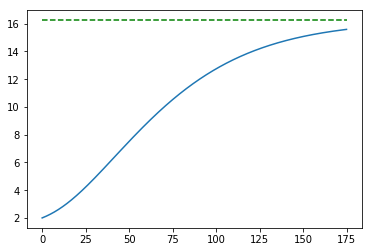

1.0017173179894752 16.249220403642664


In [8]:
vmax=(Nv)*dv0

print(Nv,len(rnpf[0]),vmax)

vrange=np.arange(0,vmax-.00000001*vmax,dv0)#*rnpf[0])/rnpf[0]
print(len(vrange))
print(vrange)
        
plt.plot(vrange,rnpf[0])
#plt.plot(dphinpvf[0])
#plt.plot(dphinpuf[0])
Mc=np.nanmax(massnpf[0])
rcosm=odeu.rc(Mc,Q,Lambda)
plt.plot([0,vmax],[rcosm,rcosm],linestyle='--',color='green')
plt.show()



#print(vrange)
print(Mc,rcosm)


In [ ]:
drunptemp=np.empty((Nv))*np.nan
#dsigunp=np.empty((Nu))*np.nan


A=.115
u1=9.5
u2=10

###Applying Propagation Algorithm###

urange=np.array([0.0],dtype=datatype)

massnpf[0][0]=1.0

#drunp[0]=-mth.exp(signpf[0][0])/(4.0*dr0v)*(1-2*M0/ru0+Q**2.0/ru0**2.0-Lambda*ru0**2/3)
#dsigunpvalue=100*np.exp(np.nanmax(signpf))
#drunptemp=drunp[0]
    

i=0
dv=dv0
if M0>0:
    du0=M0/Nul
elif M0==0:
    du0=1/Nul

du=du0

###fix this part (put in front of boundary conditions so it is an initial condition)
#if bdytype=="edd" or bdytype=="fulledd":
    #bdyvalue=1.0
    #dsignpuf[0]=2*(3*Q**2-3*M0*ru0+ru0**4*Lambda)/(ru0*(-3*Q**2+ru0*(6*M0-3*ru0+ru0**3*Lambda)))*drunp[0]
    #dsigunp[0]=2.0*(M0*rnpf[0]-Q**2.0)/(rnpf[0]*(Q**2.0+rnpf[0]*(-2*M0+rnpf[0])))*drunp[0]
#else:
    #bdyvalue=0.0
    #dsigunp[0]=0.0
######
    
atom = tables.Float64Atom()

rnpfile = tables.open_file('rnp.h5', mode='w',encoding="utf8") 
rnp = rnpfile.create_earray(rnpfile.root, 'data', atom, (0, Nv))

signpfile = tables.open_file('signp.h5', mode='w',encoding="utf8") 
signp = signpfile.create_earray(signpfile.root, 'data', atom, (0, Nv))
phinpfile = tables.open_file('phinp.h5', mode='w',encoding="utf8") 
phinp = phinpfile.create_earray(phinpfile.root, 'data', atom, (0, Nv))
massnpfile = tables.open_file('massnp.h5', mode='w',encoding="utf8") 
massnp = massnpfile.create_earray(massnpfile.root, 'data', atom, (0, Nv))
    
 
#rtemp=rnpf[0]   
#print(rtemp)
rnp.append(rnpf[0].reshape(1,Nv))
signp.append(signpf[0].reshape(1,Nv))
phinp.append(phinpf[0].reshape(1,Nv))
massnp.append(massnpf[0].reshape(1,Nv))

#drunp=np.append(drunp,np.nan)
#dsigunp=np.append(dsigunp,np.nan)
#dphinpuf=np.append(dphinpuf,np.nan)
drunptemp=np.nanmax(np.abs(drnpuf[0]))     
dsigunpvalue=np.nanmax(np.abs(dsignpuf[0]))
dphiutemp=np.nanmax(np.abs(dphinpuf[0]))

rnpf[1][0]=rnpf[0][0]

i=0
TempTol=1 
TempTolv=1
Eres=False
while max(urange)<umax and i<1000000 and du>0.0: #and rnpf[1][0]>0.0 :

    
    du=du0*Tol*TempTol/np.nanmax([abs(dsigunpvalue),abs(drunptemp),abs(dphiutemp)])
    #du=du0*Tol*TempTol/max([abs(dsigunpvalue),abs(drunptemp),abs(dphiutemp)])

    
    if du<1/Nup*1.1:
        du=1/Nup
     
    
    if du>=1/Nul:
        #print('r='+str(rnpf[i][0]))
        if rnpf[1][0]<rplus:
            du=1/(1*Nul)
            #print(rplus)
        else:
            du=1/Nul
    

    print("%.24f" % urange[i])
    print("%.24f" % du)
    
    ###fix this section (dphinpuf is in the wrong form)
    #if urange[i]>u1 and urange[i]<u2 and vscalarfield==True:
        #u=urange[i]+du
        #phinpf[1][0]=A*64*(u-u1)**3.0*(u2-u)**3.0/(u2-u1)**6.0
        #dphinpuf[i]=192*A*(u-u1)**2.0*(u-u2)**2.0*(-2*u+u1+u2)/(u1-u2)**6.0 
    #else:
        #continue
        #phinpf[1][0]=0.0
        #dphinpuf[i+1]=0.0
    

    ###Predictor###
    drnpvf[1]=drnpvf[0]+du*odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)
    dsignpvf[1]=dsignpvf[0]+du*odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)
    dphinpvf[1]=dphinpvf[0]+du*odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])
    drnpuf[1]=drnpuf[0]+du*odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])
    
    rnpf[1]=rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    signpf[1]=signpf[0]+du*dsignpuf[0]
    phinpf[1]=phinpf[0]+du*dphinpuf[0]
    
    #if np.any(phinpf[1]): 
        #dsignpuf[1][0]=0.0
        #dphinpuf[1][0]=0.0
        #for j in range(0,Nv-1):
            #dphinpuf[1][j+1]=dphinpuf[1][j]+dv*odeu.Phifunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j])         
            #dphinpuf[1][j+1]=dphinpuf[1][j]+1/2*dv*(odeu.Phifunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j])+odeu.Phifunc(drnpvf[1][j+1],drnpuf[1][j+1],dphinpuf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1]))
            #dsignpuf[1][j+1]=dsignpuf[1][j]+dv*odeu.Sigfunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j], rnpf[1][j],signpf[1][j],Q)                                                                             
            #Phifuncnp=odeu.Phifunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1])
    #else:
        #dphinpuf[1]=0.0
    #dsignpuf[1][0]=0.0
    #dphinpuf[1][0]=0.0 
    #print(dsignpuf[1])
    #print(dphinpuf[1])
    
    dphinpuf[1]=1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-1/2*dv*(np.cumsum(drnpuf[1]*dphinpvf[1]+np.roll(drnpuf[1]*dphinpvf[1],1))-(drnpuf[1][0]*dphinpvf[1][0]+np.roll(drnpuf[1]*dphinpvf[1],1)[0])))
    Sigfuncnp=odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1]=dsignpuf[1][0]+1/2*dv*(np.cumsum(Sigfuncnp+np.roll(Sigfuncnp,1))-(Sigfuncnp[0]+np.roll(Sigfuncnp,1)[0]))
    
    #print(dsignpuf[1])
    #print(dphinpuf[1])
    
    ###Correction###
    drnpvf[1]=drnpvf[0]+1/2*du*(odeu.Rfunc(drnpvf[0],drnpuf[0],rnpf[0],signpf[0],Q,Lambda)+odeu.Rfunc(drnpvf[1],drnpuf[1],rnpf[1],signpf[1],Q,Lambda))
    dsignpvf[1]=dsignpvf[0]+1/2*du*(odeu.Sigfunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0],signpf[0],Q)+odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q))
    dphinpvf[1]=dphinpvf[0]+1/2*du*(odeu.Phifunc(drnpvf[0],drnpuf[0],dphinpuf[0],dphinpvf[0],rnpf[0])+odeu.Phifunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1]))
    drnpuf[1]=drnpuf[0]+1/2*du*(odeu.Coneq(drnpuf[0],dsignpuf[0],dphinpuf[0],rnpf[0])+odeu.Coneq(drnpuf[1],dsignpuf[1],dphinpuf[1],rnpf[1]))
    
    rnpf[1]=rnpf[0]+1/2*du*(drnpuf[0]+drnpuf[1])
    signpf[1]=signpf[0]+1/2*du*(dsignpuf[0]+dsignpuf[1])
    phinpf[1]=phinpf[0]+1/2*du*(dphinpuf[0]+dphinpuf[1])
    
    #########
    #if np.any(phinpf[1]): 
        #dsignpuf[1][0]=0.0
        #dphinpuf[1][0]=0.0
        #for j in range(0,Nv-1):
            #dphinpuf[1][j+1]=dphinpuf[1][j]+1/2*dv*(odeu.Phifunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j])+odeu.Phifunc(drnpvf[1][j+1],drnpuf[1][j+1],dphinpuf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1]))         
            #dsignpuf[1][j+1]=dsignpuf[1][j]+1/2*dv*(odeu.Sigfunc(drnpvf[1][j],drnpuf[1][j],dphinpuf[1][j],dphinpvf[1][j],rnpf[1][j],signpf[1][j],Q)+odeu.Sigfunc(drnpvf[1][j+1],drnpuf[1][j+1],dphinpuf[1][j+1],dphinpvf[1][j+1],rnpf[1][j+1],signpf[1][j+1],Q))    
    #else:
        #dphinpuf[1]=0.0
    #dsignpuf[1][0]=0.0
    #dphinpuf[1][0]=0.0
    ########
    
    
    dphinpuf[1]=1/(rnpf[1])*(rnpf[1][0]*dphinpuf[1][0]-1/2*dv*(np.cumsum(drnpuf[1]*dphinpvf[1]+np.roll(drnpuf[1]*dphinpvf[1],1))-(drnpuf[1][0]*dphinpvf[1][0]+np.roll(drnpuf[1]*dphinpvf[1],1)[0])))
    Sigfuncnp=odeu.Sigfunc(drnpvf[1],drnpuf[1],dphinpuf[1],dphinpvf[1],rnpf[1],signpf[1],Q)
    dsignpuf[1]=dsignpuf[1][0]+1/2*dv*(np.cumsum(Sigfuncnp+np.roll(Sigfuncnp,1))-(Sigfuncnp[0]+np.roll(Sigfuncnp,1)[0]))

    massnpf[1]=(1+4.0*np.exp(-signpf[1])*drnpuf[1]*drnpvf[1])*rnpf[1]/2.0+np.power(Q,2.0)/(2.0*rnpf[1])-Lambda*np.power(rnpf[1],3.0)/6.0
    
    #####
    
    drunptemp=np.nanmax(np.abs(drnpuf[1]))      
    dsigunpvalue=np.nanmax(np.abs(dsignpuf[1]))    
    dphiutemp=np.nanmax(np.abs(dphinpuf[1]))
    
    #if float(dsigunpvalue*du)>1000:#0.1:
        #TempTol=TempTol/2
        #Eres=True
    #else:
        
    if urange[i]+du<umax:
        urange=np.append(urange,urange[i]+du)
    else:
        break
        
    rnp.append(rnpf[1].reshape(1,Nv))
    signp.append(signpf[1].reshape(1,Nv))
    phinp.append(phinpf[1].reshape(1,Nv))
    massnp.append(massnpf[1].reshape(1,Nv))
    
    #drunp=np.append(drunp,np.nan)
    #dsigunp=np.append(dsigunp,np.nan)
    #dphinpuf=np.append(dphinpuf,np.nan)
    print(drnpuf[1][-1])
    print(dsignpuf[1][-1])
    #print('--')
    #print(drnpvf[1][-1])
    #print(dsignpvf[1][-1])
    #print(dphinpvf[1][-1])
    #print('--')
    print(massnpf[1][-2])
    #print(dphinpuf[1][-1])
    print('---')
    
    
    rnpf[0]=rnpf[1]
    phinpf[0]=phinpf[1]
    signpf[0]=signpf[1]
    drnpvf[0]=drnpvf[1]
    dsignpvf[0]=dsignpvf[1]
    dphinpvf[0]=dphinpvf[1]
    drnpuf[0]=drnpuf[1]
    dsignpuf[0]=dsignpuf[1]
    dphinpuf[0]=dphinpuf[1]
    #massnpf[0]=massnpf[1]
    
        
        
    #if Eres==True:
        #TempTol=2*TempTol
    #else:
        #TempTol=1
    #Eres=False
    i+=1
    
    
    

    #if rnpf[1][0]<0.0 or np.isnan(du):
        #break
   
    


/home/brandon/.conda/envs/pycbc/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


0.000000000000000000000000
0.008174507165450536211315
-0.0697439128295388
0.3835105741563637
1.0017173212586536
---
0.008174507165450536211315
0.008155815230845096797108
-0.06996274662005524
0.38471947629681874
1.0017173248317937
---
0.016330322396295633008423
0.008137143870316889196492
-0.07018245524307175
0.3859324540378164
1.0017173284159506
---
0.024467466266612523939639
0.008118493138197813499546
-0.07040304233687679
0.38714951981238344
1.0017173320111388
---
0.032585959404810335704461
0.008099863207923798519294
-0.0706245115565951
0.38837068609948266
1.0017173356173723
---
0.040685822612734137693202
0.008081254165425041241511
-0.07084686657191279
0.3895959654112086
1.0017173392346717
---
0.048767076778159182404160
0.008062665970514420674120
-0.07107011106364053
0.39082537027371417
1.0017173428630528
---
0.056829742748673604813003
0.008044098821402827226290
-0.07129424873033348
0.3920589132634902
1.0017173465025309
---
0.064873841570076432039293
0.008025552816153143365074
-0.07151

-0.0924753112753707
0.505328035965247
1.0017176748993961
---
0.650248228494661462129045
0.006616907302206515018028
-0.09278553389399001
0.5069418048051084
1.0017176794834857
---
0.656865135796868004902649
0.006600309313303750514967
-0.09309700834662041
0.5085608674000376
1.0017176840796793
---
0.663465445110171803122512
0.006583737721785699881227
-0.09340973975499435
0.5101852395080245
1.0017176886879877
---
0.670049182831957468309270
0.006567192646906718639377
-0.09372373326437565
0.5118149369499149
1.001717693308417
---
0.676616375478864218173669
0.006550674132324385209869
-0.09403899404012507
0.5134499755913182
1.0017176979409728
---
0.683167049611188570423792
0.006534182124534570514085
-0.09435552726307748
0.5150903713184222
1.0017177025856663
---
0.689701231735723174764985
0.006517716747752516810721
-0.09467333813818159
0.5167361400826213
1.0017177072425012
---
0.696218948483475652544428
0.006501278060116913275202
-0.09499243189147542
0.5183872978845002
1.0017177119114846
---
0.70

-0.12651141018795983
0.6759014279032963
1.0017181422548402
---
1.187726013736150498800725
0.005218855644312912593630
-0.12695917489971145
0.6780673689932253
1.0017181479582948
---
1.192944869380463401853376
0.005204786817330047700436
-0.1274087495156544
0.6802402424285134
1.0017181536740907
---
1.198149656197793344603042
0.005190746517981935544139
-0.12786014132443752
0.6824200687713504
1.0017181594022304
---
1.203340402715775248054797
0.005176734775345955517911
-0.12831335764521645
0.6846068686572164
1.001718165142715
---
1.208517137491121218317858
0.005162751572284021532588
-0.12876840582378857
0.6868006627759436
1.001718170895539
---
1.213679889063405292759512
0.005148796859411833987119
-0.1292252932298092
0.6890014718579879
1.0017181766606997
---
1.218828685922817234299487
0.005134870708001533848308
-0.12968402726759784
0.6912093167263291
1.0017181824381929
---
1.223963556630818683146344
0.005120973118592612310929
-0.13014461537011018
0.6934242182669056
1.0017181882280184
---
1.229

1.592150236603068425011998
0.004101015133970044648781
-0.17371299533159068
0.8954515215639858
1.0017186909729086
---
1.596251251737038412414904
0.004089398389213992797420
-0.1743512922302293
0.8983135787630364
1.0017186977450079
---
1.600340650126252484142242
0.004077809038772063632283
-0.1749921611216473
0.9011846414316754
1.0017187045289493
---
1.604418459165024568591207
0.004066247095023707049111
-0.17563561223887963
0.9040647365385068
1.0017187113247212
---
1.608484706260048247017380
0.004054712531384824410197
-0.1762816558544762
0.9069538911367434
1.0017187181323166
---
1.612539418791433032396299
0.004043205254244390534080
-0.17693030226990414
0.909852132316436
1.0017187249517292
---
1.616582624045677318846970
0.004031725301183369802871
-0.17758156183663504
0.9127594872984348
1.0017187317829457
---
1.620614349346860771916568
0.004020272647624276336764
-0.1782354449465494
0.9156759833910003
1.0017187386259616
---
1.624634621994484939833114
0.004008847233679236829462
-0.178891962026

-0.2436861028773912
1.1962901987071284
1.001719354579814
---
1.924174631252024036953685
0.003143145443006435321709
-0.24460557448648518
1.2000931907440715
1.001719362390082
---
1.927317776695030460132330
0.003133915436325033967296
-0.245528730876177
1.203908023699245
1.001719370211287
---
1.930451692131355478920796
0.003124709647641914743443
-0.246455586576926
1.2077347334972888
1.0017193780434193
---
1.933576401778997366776025
0.003115528027383033995296
-0.24738615617302007
1.2115733561670636
1.0017193858864646
---
1.936691929806380496614793
0.003106370496325328717235
-0.24832045429379093
1.2154239278049859
1.0017193937404176
---
1.939798300302705724718066
0.003097237058504045004864
-0.24925849563876978
1.2192864846782532
1.0017194016052633
---
1.942895537361209790105931
0.003088127671991282904157
-0.25020029496434765
1.2231610631691363
1.0017194094809945
---
1.945983665033200971095084
0.003079042260180082490190
-0.2511458670733368
1.2270476997316309
1.001719417367597
---
1.9490627072

-0.3378423391266004
1.5705554746043506
1.0017200651724405
---
2.163135719300529835606994
0.002433430918557627411353
-0.33913803327168346
1.5755204740340572
1.0017200738856458
---
2.165569150219087468656198
0.002426124045091477849506
-0.3404388908451757
1.5805008575385828
1.0017200826089239
---
2.167995274264178817702486
0.002418837580700250108889
-0.34174493208231194
1.5854966722051362
1.001720091342265
---
2.170414111844879201385083
0.002411571510666792646921
-0.34305617731292315
1.5905079653319203
1.0017201000856595
---
2.172825683355545933750363
0.002404325789878418873774
-0.3443726469456115
1.5955347843668242
1.0017201088391001
---
2.175230009145424414640502
0.002397100341155464220400
-0.34569436145031057
1.6005771768401755
1.0017201176025772
---
2.177627109486580003760992
0.002389895142704523932353
-0.347021341388828
1.605635190480685
1.0017201263760818
---
2.180017004629284382843935
0.002382710158573445730079
-0.34835360740765237
1.6107088731872317
1.0017201351596032
---
2.182399

-0.4703938278061231
2.0589297630472845
1.0017208504535091
---
2.347699670434513663508369
0.001875133749035994652418
-0.47221628177854535
2.0654062948678122
1.0017208600027443
---
2.349574804183549581182433
0.001869421233518429436432
-0.47404596049472403
2.0719028576836194
1.0017208695613808
---
2.351444225417067990235864
0.001863725374668605489284
-0.47588289219125524
2.078419513280551
1.001720879129417
---
2.353307950791736491424899
0.001858046102308204576212
-0.4777271051864229
2.084956323540172
1.001720888706843
---
2.355165996894044599940798
0.001852383398381172215780
-0.4795786279318713
2.0915133506220607
1.0017208982936507
---
2.357018380292425607791529
0.001846737224738733253518
-0.48143748899351774
2.098090656895096
1.001720907889836
---
2.358865117517164211591307
0.001841107527315296926371
-0.4833037170358735
2.1046883048811504
1.0017209174953958
---
2.360706225044479467101155
0.001835494256522377356025
-0.48517734082657366
2.1113063572702133
1.001720927110319
---
2.3625417193

-0.6643754612514593
2.7212939973768515
1.0017217365263837
---
2.494006429123845069995014
0.001427269982921247539615
-0.6669649771727006
2.7298186319481204
1.0017217468917332
---
2.495433699106766489705933
0.001422880950780444674411
-0.6695647105340546
2.7383696237940183
1.0017217572660586
---
2.496856580057547070339297
0.001418505054734822603407
-0.6721747011396235
2.746947054398662
1.0017217676493564
---
2.498275085112281690413738
0.001414142271887018501367
-0.6747949889721208
2.7555510055805796
1.0017217780416257
---
2.499689227384168876966442
0.001409792565969878591625
-0.677425614169161
2.764181559413452
1.0017217884428602
---
2.501099019950138835355347
0.001405455877739338575727
-0.6800666169803902
2.7728387980846794
1.0017217988530591
---
2.502504475827878049898345
0.001401132193278035098158
-0.6827180378524887
2.7815228041728868
1.0017218092722198
---
2.503905608021156137255048
0.001396821477616818404227
-0.6853799173908367
2.7902336605207556
1.0017218197003368
---
2.50530242949

-0.9324732319321845
3.5707757774663267
1.0017226716075989
---
2.603074631305487773857976
0.001090913076817551664172
-0.9361183609439806
3.5819271990091717
1.0017226827445906
---
2.604165544382305519377496
0.001087539720956313092637
-0.9397778162404757
3.5931131078670946
1.0017226938903736
---
2.605253084103261951298691
0.001084176619608205301495
-0.9434516534832552
3.60433361068394
1.0017227050449513
---
2.606337260722870308171650
0.001080823761398039088710
-0.9471399286108761
3.6155888146231034
1.0017227162083202
---
2.607418084484268483436153
0.001077481116564031789207
-0.9508426977782303
3.6268788271807284
1.0017227273804803
---
2.608495565600832399866249
0.001074148645844705219840
-0.9545600173241281
3.6382037560853355
1.0017227385614298
---
2.609569714246676941371561
0.001070826320457583845716
-0.9582919438073542
3.64956370940656
1.0017227497511696
---
2.610640540567134681992911
0.001067514119775672979881
-0.9620385340360557
3.660958795642837
1.001722760949698
---
2.61170805468691

-1.3354346697617057
4.755456144384538
1.0017237329547068
---
2.690527508929614786126194
0.000820006229194551001724
-1.3406604971758795
4.770271913189593
1.001723744899099
---
2.691347515158809322599609
0.000817461839735312873097
-1.3459067897639085
4.785133514324269
1.001723756852276
---
2.692164976998544734243524
0.000814925279206424563010
-1.351173626943963
4.8000410897403425
1.0017237688142338
---
2.692979902277750969830095
0.000812396524151072756820
-1.3564610884405475
4.81499478182864
1.0017237807849764
---
2.693792298801902074245618
0.000809875543168886869588
-1.361769254233004
4.829994733272049
1.001723792764504
---
2.694602174345070988437101
0.000807362315145313327869
-1.3670982046225368
4.84504108723281
1.0017238047528192
---
2.695409536660216431869230
0.000804856822741249538708
-1.3724480202586404
4.860133987425327
1.0017238167499194
---
2.696214393482957660808097
0.000802359041677980829727
-1.3778187820946117
4.875273577988251
1.0017238287558081
---
2.69701675252463557441728

2.753754684670503660726126
0.000623629990892655364926
-1.8904893675536052
6.2707801031958335
1.0017248305023942
---
2.754378314661396487394995
0.000621691331527863925988
-1.897885289915182
6.290283790213754
1.001724843232311
---
2.755000005992924272391065
0.000619758671732955159807
-1.905310085716525
6.309847816477507
1.0017248559711147
---
2.755619764664657189712216
0.000617831991888126972647
-1.9127638667204896
6.3294723686892596
1.001724868718802
---
2.756237596656545107975944
0.000615911265849390264157
-1.9202467450229406
6.349157633873629
1.0017248814753748
---
2.756853507922394364015872
0.000613996484761864772146
-1.9277588332626134
6.368903799927325
1.0017248942408346
---
2.757467504407156155821212
0.000612087630491398981131
-1.9353002445113499
6.3887110553270725
1.001724907015185
---
2.758079592037647742586159
0.000610184678391429129868
-1.9428710921940058
6.408579588917272
1.001724919798428
---
2.758689776716038988269020
0.000608287613168247295013
-1.9504714902038456
6.4285095

-2.654813277357178
8.214462544506945
1.001725971411589
---
2.801830410274459559616389
0.000474097864579332861114
-2.6651885883945203
8.239979124114843
1.0017259849206193
---
2.802304508139038752290162
0.000472622525697339083105
-2.6756042879218427
8.265574633754772
1.001725998438685
---
2.802777130664736215948096
0.000471151767716019393914
-2.6860605318916293
8.291249317477025
1.0017260119657871
---
2.803248282432452054280247
0.000469685571121586289273
-2.696557476732867
8.31700341978714
1.0017260255019282
---
2.803717968003573535185069
0.000468223924652367781436
-2.7070952795344714
8.34283718609352
1.0017260390471092
---
2.804186191928225824199217
0.000466766816953883634592
-2.717674098046663
8.368750862707119
1.0017260526013292
---
2.804652958745179613941900
0.000465314232666474232505
-2.728294090592661
8.394744696620927
1.001726066164597
---
2.805118272977845883531245
0.000463866152647446285291
-2.7389554159816503
8.420818935294866
1.0017260797369083
---
2.805582139130493146694789
0

-3.770292449435857
10.85775037217488
1.0017272236326127
---
2.839094177379448691311836
0.000358102933065712538286
-3.785003398323485
10.891442002705372
1.0017272379624425
---
2.839452280312514620419506
0.000356987928829188220625
-3.7997714458422824
10.925237813351591
1.0017272523014809
---
2.839809268241343609417981
0.000355876393232949219878
-3.814596811815599
10.959138125893237
1.0017272666497261
---
2.840165144634576588344999
0.000354768315527925716044
-3.8294797169060244
10.993143263102077
1.0017272810071836
---
2.840519912950104419735453
0.000353663680660102925247
-3.8444203824346634
11.027253548323063
1.001727295373854
---
2.840873576630764674177954
0.000352562480600277026576
-3.859419030676364
11.061469306146783
1.0017273097497421
---
2.841226139111364901168599
0.000351464706438123230831
-3.8744758848275134
11.095790862330315
1.0017273241348459
---
2.841577603817802888386268
0.000350370346253168736886
-3.889591168880107
11.130218543505507
1.0017273385291707
---
2.841927974164056

-5.413815843932201
14.481542139579922
1.0017285959400217
---
2.868047960232191773144450
0.000267937640022725999389
-5.434895695958469
14.526436081687262
1.0017286111340837
---
2.868315897872214303987448
0.000267103142949461872403
-5.45605711571017
14.571468766663418
1.0017286263375231
---
2.868583001015163613800496
0.000266271241108981520512
-5.477300415883668
14.61664062196943
1.001728641550339
---
2.868849272256272620040818
0.000265441928808517830975
-5.498625910549847
14.66195207677705
1.0017286567725359
---
2.869114714185081016495360
0.000264615199107304645363
-5.520033915061847
14.70740356176646
1.0017286720041119
---
2.869379329384188270779532
0.000263791042801977222362
-5.54152474587567
14.752995508738728
1.0017286872450715
---
2.869643120426990101634601
0.000262969449726458814193
-5.56309872047002
14.798728350442438
1.0017287024954138
---
2.869906089876716581699156
0.000262150415273667994429
-5.584756157803366
14.8446025215365
1.0017287177551415
---
2.870168240291990358059593
0

-7.618370978800788
19.013491905252753
1.0017299690804533
---
2.888699169243508890758676
0.000203614759275395939327
-7.64796788745301
19.072386967004253
1.001729985105463
---
2.888902784002784329686619
0.000202980520728076799372
-7.677678974025343
19.131463920678407
1.001730001139979
---
2.889105764523512309693842
0.000202348255794488707335
-7.707504674733293
19.190723326109342
1.0017300171839993
---
2.889308112779306991768635
0.000201717960783119940179
-7.737445427801633
19.250165745564086
1.001730033237525
---
2.889509830740089935119386
0.000201089629557594016087
-7.767501673113668
19.309791743037092
1.0017300493005603
---
2.889710920369647606520402
0.000200463253254547034811
-7.797673851802677
19.369601883433067
1.0017300653731072
---
2.889911383622902008028177
0.000199838827856719462427
-7.827962406977798
19.42959673400101
1.001730081455162
---
2.890111222450758798885317
0.000199216347982047282473
-7.858367783529213
19.489776863939728
1.00173009754673
---
2.890310438798740833021839


-10.71196543841302
24.95824137843488
1.0017314157852244
---
2.904392527019277192579239
0.000154730347996732969665
-10.753477004459798
25.035489050476418
1.0017314326506552
---
2.904547257367273704886657
0.000154248357341883111883
-10.79514820178573
25.112975109862337
1.0017314495256748
---
2.904701505724615717696224
0.000153767868320648124847
-10.836979638346198
25.190700290183308
1.001731466410284
---
2.904855273592936271143117
0.000153288876688318146096
-10.878971924504452
25.268665327499402
1.0017314833044813
---
2.905008562469624688873182
0.000152811376893148944192
-10.921125672678428
25.346870959675485
1.001731500208269
---
2.905161373846517847141513
0.000152335363439337162462
-10.963441497352294
25.425317926395515
1.001731517121648
---
2.905313709209957018231307
0.000151860833436704063294
-11.005920015804026
25.504006970502765
1.0017315340446187
---
2.905465570043393785937269
0.000151387782259931749987
-11.048561847636387
25.58293883711902
1.0017315509771825
---
2.905616957825653

-15.16498066348791
32.95749285821456
1.0017329721308652
---
2.916552930792233766510435
0.000116850122376838583185
-15.223585410687816
33.059415194145714
1.0017329898608933
---
2.916669780914610488053995
0.000116486129226137110986
-15.282414739545512
33.161651785098655
1.001733007600536
---
2.916786267043836478052299
0.000116123268780436708831
-15.341469501095625
33.26420359569136
1.0017330253497914
---
2.916902390312616777379162
0.000115761539009659922381
-15.4007505503158
33.36707159480811
1.0017330431086613
---
2.917018151851626495130176
0.000115400936638106633037
-15.46025874551479
33.47025675452308
1.0017330608771449
---
2.917133552788264694299869
0.000115041457407415680363
-15.519994947831009
33.57376004921666
1.0017330786552412
---
2.917248594245672066449515
0.000114683097332387564857
-15.579960021368487
33.677582455807965
1.0017330964429512
---
2.917363277343004490660405
0.000114325854157917939443
-15.640154834108161
33.7817249553132
1.001733114240273
---
2.917477603197162316917

-21.28326844484068
43.24284585279721
1.0017345691419006
---
2.925558978657964548375503
0.000088795980746365934491
-21.365275362722773
43.37646526701732
1.0017345877165056
---
2.925647774638711062777929
0.000088519380334717141204
-21.447595402951855
43.51049627186521
1.0017346063006753
---
2.925736294019045669045909
0.000088243641126876538731
-21.53022974724596
43.64494012977152
1.0017346248944143
---
2.925824537660172364184064
0.000087968761333379879718
-21.61317958255889
43.77979810838023
1.001734643497719
---
2.925912506421505909770531
0.000087694738272919500743
-21.69644610026782
43.915071479215115
1.0017346621105858
---
2.926000201159778768555952
0.000087421567904212034829
-21.78003049487671
44.0507615155561
1.0017346807330183
---
2.926087622727683079659755
0.000087149248812958153825
-21.863933966516758
44.186869496491816
1.001734699365012
---
2.926174771976496113978783
0.000086877778475054413571
-21.948157719916377
44.32339670522453
1.0017347180065688
---
2.92626164975497138343030

-29.611241128386435
56.3763636046987
1.001736201403478
---
2.932267220008255126373342
0.000067899895563345983619
-29.72498401072808
56.5504174428464
1.00173622079617
---
2.932335119903818565489928
0.000067688390276786385884
-29.83915954329036
56.725006876295474
1.001736240198304
---
2.932402808294095386543177
0.000067477544194353714850
-29.95376935246078
56.90013354740384
1.0017362596098778
---
2.932470285838289836277681
0.000067267354166639502125
-30.06881506877808
57.075799100683625
1.001736279030892
---
2.932537553192456680761779
0.000067057819185035335533
-30.184298330577526
57.25200518834975
1.0017362984613394
---
2.932604611011641715379028
0.000066848937267284422011
-30.300220782369113
57.42875346782521
1.0017363179012202
---
2.932671459948909209458634
0.000066640705863295438558
-30.41658407385717
57.606045600222735
1.0017363373505352
---
2.932738100654772583908425
0.000066433122830260562717
-30.533389860638735
57.783883251400084
1.001736356809281
---
2.932804533777602973287912
0

-41.62889762184819
74.16383599580799
1.001737964073735
---
2.937552122597235637613267
0.000051437784311683045922
-41.78825322200898
74.39259319474878
1.001737984297618
---
2.937603560381547129765067
0.000051277560620935495374
-41.94821241844034
74.62205351734322
1.0017380045307176
---
2.937654837942167862507858
0.000051117835838070006598
-42.108777466956084
74.8522191144232
1.0017380247730312
---
2.937705955778005861844804
0.000050958608863556668304
-42.269950633095604
75.08309214541426
1.0017380450245552
---
2.937756914386869588895479
0.000050799878144165347546
-42.43173419073811
75.31467477632299
1.0017380652852852
---
2.937807714265013636634194
0.000050641641277183304184
-42.59413041938358
75.54696917582679
1.0017380855552176
---
2.937858355906290963588390
0.000050483897567093624842
-42.75714160960368
75.77997752305279
1.0017381058343533
---
2.937908839803858196404462
0.000050326645489656407744
-42.92077006044634
76.01370200383562
1.001738126122686
---
2.937959166449347847560603
0.0

2.941633539277492825902982
0.000038724665550533966362
-59.12436578358891
98.44230220919106
1.001739862818769
---
2.941672263943043486023043
0.000038604043871762632508
-59.34982873886285
98.74563457096058
1.0017398838756804
---
2.941710867986915278748938
0.000038483797800945929515
-59.57614168268253
99.04989808306915
1.0017399049414606
---
2.941749351784716193236591
0.000038363926486472154948
-59.80330777532298
99.35509559188736
1.0017399260161035
---
2.941787715711202455537432
0.000038244428746455190428
-60.03133018853382
99.66122995233938
1.0017399470996078
---
2.941825960139949014404692
0.000038125302786577371127
-60.26021210186667
99.96830402294933
1.0017399681919654
---
2.941864085442735810005388
0.000038006548092396041905
-60.489956710326965
100.2763206760862
1.0017399892931746
---
2.941902091990828083112319
0.000037888163505540284315
-60.72056722059434
100.58528279285454
1.0017400104032288
---
2.941939980154333778017417
0.000037770147533922998053
-60.95204684898982
100.8951932603

128.6374282064478
1.0017417274372646
---
2.944618209390529539604131
0.000029427909647609527317
-82.59412671693347
129.03338996581158
1.0017417492473109
---
2.944647637300177311914240
0.000029336246933984804034
-82.90784947484734
129.43056563441863
1.0017417710657752
---
2.944676973547111220597117
0.000029244869887999336955
-83.22274924620605
129.828958916723
1.001741792892652
---
2.944706218416999199405382
0.000029153777618384438811
-83.53883038100645
130.22857352841464
1.001741814727938
---
2.944735372194617450958276
0.000029062968960899093589
-83.85609724200374
130.62941319265352
1.0017418365716275
---
2.944764435163578220056024
0.000028972443086077590354
-84.17455420832519
131.03148164458534
1.0017418584237112
---
2.944793407606664192854851
0.000028882199335187579706
-84.4942056774114
131.43478263377767
1.0017418802841846
---
2.944822289805999471212772
0.000028792236801139730153
-84.81505606234926
131.8393199207823
1.0017419021530443
---
2.944851082042800438642871
0.0000287025541680

-114.78935665476233
168.56275028172536
1.001743678267471
---
2.946886343267139718449243
0.000022363119037497445241
-115.22354847718914
169.08102313011264
1.001743700794091
---
2.946908706386177190239550
0.000022293462549004538906
-115.65936091849153
169.60088259369434
1.001743723328547
---
2.946930999848726084877626
0.000022224023140763942227
-116.09679992992814
170.1223335053564
1.0017437458708343
---
2.946953223871866978100797
0.000022154800102719411121
-116.53587148351907
170.64538071183568
1.0017437684209436
---
2.946975378671969902910632
0.000022085792446668868320
-116.97658156648689
171.1700290670661
1.0017437909788667
---
2.946997464464416793816781
0.000022016999849033605237
-117.41893619447283
171.6962834478744
1.0017438135445977
---
2.947019481464265844294914
0.000021948421638867043817
-117.86294140475731
172.2241487458468
1.0017438361181301
---
2.947041429885904673113828
0.000021880056926751155358
-118.30860325182759
172.75362986202356
1.0017438586994527
---
2.947063309942831

-153.42971501328253
213.48619128276846
1.001745435182967
---
2.948419485603033685094942
0.000017587715010618739145
-154.00777218579015
214.14189690150425
1.0017454582900696
---
2.948437073318044276959426
0.000017532933192744518672
-154.5879764500104
214.79960716692625
1.0017454814043876
---
2.948454606251237120062569
0.000017478322096664292910
-155.17033564268127
215.45932817455898
1.0017455045259092
---
2.948472084573333873436241
0.000017423881155377981346
-155.75485762736446
216.121066037026
1.0017455276546285
---
2.948489508454489094191331
0.000017369609608972851874
-156.34155028790795
216.78482687660434
1.0017455507905355
---
2.948506878064097946889888
0.000017315507194341670335
-156.93042154517389
217.45061684411195
1.0017455739336198
---
2.948524193571292251192517
0.000017261573383836307545
-157.5214793482972
218.11844210893264
1.001745597083874
---
2.948541455144676248778524
0.000017207807469509140184
-158.11473166848936
218.78830885198295
1.0017456202412909
---
2.94855866295214

-213.4466013772906
279.5757000212667
1.001747495212241
---
2.949775047508828240694356
0.000013365452716207405526
-214.24689556353943
280.43328627922364
1.001747518918362
---
2.949788412961544370460842
0.000013323822471947103228
-215.0501445815835
281.29349003706096
1.0017475426308486
---
2.949801736784016359393945
0.000013282321962171396819
-215.85635913593663
282.1563192364797
1.0017475663496915
---
2.949815019105978652902422
0.000013240950635146993798
-216.66554995995557
283.02178183345626
1.001747590074877
---
2.949828260056613693507188
0.000013199708155922133487
-217.47772782896797
283.8898858122432
1.0017476138063963
---
2.949841459764769524554140
0.000013158594202929724151
-218.2929035612964
284.76063918635975
1.0017476375442405
---
2.949854618358972668801243
0.000013117608341803565827
-219.11108801141953
285.63404999123435
1.0017476612883978
---
2.949867735967314441580811
0.000013076750015541756706
-219.93229206222517
286.51012627585317
1.0017476850388554
---
2.94988081271733015

-294.25188282370675
363.7606460543154
1.001749556088447
---
2.950784772602829786336542
0.000010220398709160065392
-295.3495612329417
364.87494895663616
1.0017495803016154
---
2.950794993001538912835713
0.000010188564579774195420
-296.45126704402696
365.99264691400697
1.001749604520175
---
2.950805181566118484681738
0.000010156829599833383230
-297.55701472591613
367.1137501969807
1.0017496287441108
---
2.950815338395718523401001
0.000010125193516577415416
-298.6668188043083
368.2382691131125
1.0017496529734147
---
2.950825463589235031491853
0.000010093655990536889547
-299.7806938523206
369.36621399743564
1.0017496772080725
---
2.950835557245225615474737
0.000010062216603646712375
-300.8986544816738
370.49759520345043
1.0017497014480727
---
2.950845619461829105745210
0.000010030875192409638444
-302.0207153709092
371.6324231316323
1.0017497256934011
---
2.950855650337021351958811
0.000009999631451181419843
-303.1468912499292
372.7707082136635
1.001749749944047
---
2.9508656499684726703947

-391.6877361111091
460.29076712251265
1.0017514353560588
---
2.951485450294356382983096
0.000008037954081466360811
-393.1418060789494
461.69892328203855
1.0017514599471542
---
2.951493488248437824239545
0.000008012917730396927810
-394.60117890904695
463.1113624738434
1.0017514845426434
---
2.951501501166168051071281
0.000007987959360050590283
-396.0658735081861
464.52809762558826
1.0017515091425118
---
2.951509489125528240549556
0.000007963078767864013199
-397.5359088560742
465.94914171073935
1.0017515337467437
---
2.951517452204296176887510
0.000007938275683142087096
-399.01130399296585
467.3745077365334
1.00175155835533
---
2.951525390479979193969484
0.000007913549784561088054
-400.492078010057
468.8042087346274
1.0017515829682533
---
2.951533304029763549181098
0.000007888900939796751475
-401.97825008477963
470.23825779504705
1.0017516075855006
---
2.951541192930703161323436
0.000007864328908475882242
-403.4698394610046
471.67666804699786
1.0017516322070588
---
2.95154905725961169693

-530.3273810443012
591.1991872826153
1.0017534651644793
---
2.952067917946463726508455
0.000006223703085426344173
-532.2852736979418
593.0051136533637
1.0017534900684453
---
2.952074141649549066102054
0.000006204317677061440914
-534.2502575255827
594.8165220467876
1.0017535149756145
---
2.952080345967226016057339
0.000006184992679488313952
-536.2223575991261
596.6334289740112
1.0017535398859705
---
2.952086530959905363857843
0.000006165727826602131195
-538.2015990513778
598.4558509723564
1.0017535647994942
---
2.952092696687731887550399
0.000006146522980899029198
-540.1880071169942
600.283804642948
1.0017535897161762
---
2.952098843210712697526787
0.000006127377983391841943
-542.181607126101
602.1173066446838
1.0017536146359967
---
2.952104970588695920241662
0.000006108292622718740650
-544.1824244874789
603.956373678671
1.0017536395589426
---
2.952111078881318739774997
0.000006089266657794765026
-546.1904846785468
605.801022478901
1.0017536644849971
---
2.952117168147976755676609
0.000

-701.2143740862266
745.2991992065662
1.0017553658857876
---
2.952489684861995478115659
0.000004909994150773840574
-703.7890301793509
747.5724342888482
1.001755390987947
---
2.952494594856146292727317
0.000004894700576151730164
-706.3729475230076
749.8525561223446
1.0017554160920867
---
2.952499489556722256367038
0.000004879454661048062557
-708.9661585754103
752.1395853913407
1.0017554411981893
---
2.952504369011383467125142
0.000004864256256789224523
-711.568695904713
754.4335428415391
1.0017554663062387
---
2.952509233267640365028228
0.000004849105151895654784
-714.1805921551708
756.7344492500674
1.0017554914162163
---
2.952514082372792447728216
0.000004834001242639743511
-716.8018801047198
759.042325476162
1.0017555165281085
---
2.952518916374035296001921
0.000004818944401771190630
-719.4325926529874
761.357192450399
1.0017555416418946
---
2.952523735318437037022932
0.000004803934460885356036
-722.0727627990681
763.6790711550141
1.0017555667575602
---
2.952528539252897932243513
0.000

-935.8851075359245
947.8338886826517
1.0017573536993312
---
2.952834009026096051542254
0.000003837498264891701813
-939.3006039336632
950.7199951012296
1.001757378904657
---
2.952837846524360987388036
0.000003825545275823443146
-942.728292603932
953.6148250627532
1.0017574041105788
---
2.952841672069636658193303
0.000003813629484302719429
-946.168215811511
956.5184046446734
1.0017574293170792
---
2.952845485699120864353517
0.000003801750812167103553
-949.6204159960145
959.430760029824
1.0017574545241361
---
2.952849287449933246563205
0.000003789909157626045009
-953.0849357514758
962.351917489008
1.0017574797317352
---
2.952853077359090860909419
0.000003778104386550825854
-956.5618177970296
965.281903356102
1.001757504939858
---
2.952856855463477536716255
0.000003766336356643742080
-960.0511049688569
968.2207440211307
1.0017575301484838
---
2.952860621799834106582239
0.000003754604999596705111
-963.5528402886835
971.1684659878727
1.0017575553575955
---
2.952864376404833901545999
0.000003

-1246.8408161365064
1204.898448229088
1.0017593452873172
---
2.953103121924393281716448
0.000002999265835881817277
-1251.3616752250437
1208.5605685691264
1.0017593704821617
---
2.953106121190228972039904
0.000002989923698147981893
-1255.8985401307905
1212.233730142646
1.0017593956761068
---
2.953109111113926932290497
0.000002980610673446168212
-1260.4514658070177
1215.9179658846056
1.0017594208691367
---
2.953112091724600318798366
0.000002971326654985534008
-1265.0205073633745
1219.6133088067613
1.0017594460612318
---
2.953115063051255262394079
0.000002962071533470184974
-1269.605720061296
1223.3197919938498
1.001759471252368
---
2.953118025122788647962579
0.000002952845253865945989
-1274.2071593979797
1227.0374486712628
1.0017594964425296
---
2.953120977968042293326789
0.000002943647726201353477
-1278.8248810533303
1230.766312161955
1.0017595216316972
---
2.953123921615768310289241
0.000002934478819783429621
-1283.4589408255606
1234.5064158342664
1.0017595468198488
---
2.9531268560945

-1706.279474945481
1568.5226080940702
1.001761531776305
---
2.953332001682193563851797
0.000002286347940503543168
-1712.4187962490073
1573.2793293901227
1.0017615568183593
---
2.953334288030133869540350
0.000002279226360070263963
-1718.579641262191
1578.0503476311214
1.0017615818577594
---
2.953336567256493960798025
0.000002272126972827833495
-1724.7620829335383
1582.8357052670065
1.0017616068944855
---
2.953338839383466751797869
0.000002265049709545300038
-1730.9661944475743
1587.6354448714292
1.0017616319285165
---
2.953341104433176322885402
0.000002257994468596760195
-1737.1920491353403
1592.449609072408
1.0017616569598304
---
2.953343362427645057977088
0.000002250961207999540930
-1743.4397206376045
1597.2782406784202
1.0017616819884083
---
2.953345613388853152514457
0.000002243949865328471078
-1749.7092828501106
1602.12138263565
1.001761707014229
---
2.953347857338718629449659
0.000002236960359046783132
-1756.0008098703267
1606.9790779868752
1.001761732037269
---
2.9533500942990777

-2239.6524946613104
1973.9273918947974
1.0017634259307482
---
2.953486942233941370261618
0.000001803734268724025965
-2247.6529454497195
1979.900741007235
1.0017634507109547
---
2.953488745968209983061570
0.000001798115928060697914
-2255.6811855876012
1985.891989029579
1.0017634754868903
---
2.953490544084138136327056
0.000001792515076486875853
-2263.737308009412
1991.9011887932522
1.001763500258536
---
2.953492336599214507231181
0.000001786931679079699054
-2271.8214060323708
1997.9283933476968
1.0017635250258665
---
2.953494123530893578077894
0.000001781365681391407068
-2279.9335732702543
2003.9736558957313
1.0017635497888626
---
2.953495904896574764109118
0.000001775817002745755606
-2288.0739035128586
2010.0370297036861
1.0017635745475035
---
2.953497680713577544509008
0.000001770285611631960925
-2296.2424909496863
2016.1185682676921
1.0017635993017675
---
2.953499450999188979949395
0.000001764771458198562987
-2304.439430087969
2022.21832525251
1.0017636240516299
---
2.953501215770647

-2954.6525933540943
2497.8479094832896
1.0017653443005026
---
2.953612018641098568849657
0.000001414140227537918714
-2965.1235720811246
2505.388373135827
1.0017653686817927
---
2.953613432781326153531154
0.000001409735375806539188
-2975.630547975599
2512.951351489889
1.001765393057095
---
2.953614842516702143626617
0.000001405344251159801896
-2986.1736398579947
2520.5369107126917
1.0017654174263808
---
2.953616247860953336612511
0.000001400966810776392411
-2996.7529669188343
2528.145117160987
1.0017654417896356
---
2.953617648827763897401155
0.000001396602990626972033
-3007.3686485569838
2535.7760372646053
1.0017654661468332
---
2.953619045430754486147862
0.000001392252767093853654
-3018.0208046845364
2543.42973774548
1.0017654904979494
---
2.953620437683521782190610
0.000001387916100386231398
-3028.709555606586
2551.106285530889
1.0017655148429652
---
2.953621825599622052749282
0.000001383592938911801302
-3039.435021930129
2558.8057476877493
1.0017655391818574
---
2.953623209192560938

-3916.4501425488966
3177.9766173509834
1.0017672740283228
---
2.953712293284397105708194
0.000001101798072192845447
-3930.208265261325
3187.543610701181
1.0017672978592542
---
2.953713395082469439500983
0.000001098366101249271949
-3944.0131435174794
3197.139050960508
1.0017673216823837
---
2.953714493448570621580984
0.000001094944824007248126
-3957.864929187169
3206.763021150804
1.0017673454976952
---
2.953715588393394764210598
0.000001091534208721346015
-3971.763774622132
3216.4156045429195
1.0017673693051645
---
2.953716679927603561139904
0.000001088134214372249623
-3985.709832537375
3226.0968845738985
1.0017673931047693
---
2.953717768061817849911677
0.000001084744804765088935
-3999.7032560702646
3235.8069448881633
1.001767416896483
---
2.953718852806622496842692
0.000001081365957821827152
-4013.744198963012
3245.545869463576
1.0017674406802881
---
2.953719934172580163789235
0.000001077997640592367416
-4027.8328154246387
3255.313742515519
1.0017674644561605
---
2.9537210121702206500

-5124.387338801239
4004.2713593890217
1.001769084527601
---
2.953787828686039951264775
0.000000866513923890938885
-5142.225332606488
4016.2896093147606
1.001769107691416
---
2.953788695199963676429888
0.000000863814818739130331
-5160.123215753142
4028.343429519877
1.0017691308456755
---
2.953789559014782462043058
0.000000861124124140280675
-5178.08117946853
4040.4329230116787
1.0017691539903584
---
2.953790420138906469560425
0.000000858441814779319617
-5196.099415564965
4052.5581930974195
1.0017691771254447
---
2.953791278580721435531586
0.000000855767858053469383
-5214.1781162856405
4064.719343280468
1.001769200250905
---
2.953792134348579345726193
0.000000853102226184112945
-5232.317474402824
4076.916477326233
1.0017692233667195
---
2.953792987450805540561305
0.000000850444901462632218
-5250.5176834325475
4089.1496994061886
1.0017692464728658
---
2.953793837895707152796376
0.000000847795857974885120
-5268.778937462707
4101.419113981975
1.0017692695693226
---
2.95379468569156511392748

-6803.953252125043
5117.536938110353
1.0017709502156553
---
2.953850619994715209770675
0.000000670924936637240290
-6827.389657438381
5132.840591896499
1.0017709725205277
---
2.953851290919651706445848
0.000000668835062447840699
-6850.903636506511
5148.189278167611
1.0017709948139895
---
2.953851959754714151529242
0.000000666751701138084093
-6874.495431983707
5163.583126032228
1.0017710170960146
---
2.953852626506415113283310
0.000000664674821411797879
-6898.165286826235
5179.022264695906
1.0017710393665773
---
2.953853291181236517815023
0.000000662604413677664724
-6921.913445059533
5194.506823961476
1.001771061625663
---
2.953853953785650077179525
0.000000660540458169725052
-6945.740151421584
5210.036933996103
1.0017710838732403
---
2.953854614326108407595939
0.000000658482929519112124
-6969.645651158732
5225.612725197994
1.001771106109293
---
2.953855272809037924020004
0.000000656431806916299115
-6993.63019018603
5241.234328300737
1.0017711283337996
---
2.953855929240845057393017
0.00

-9098.399513263234
6592.599371822026
1.0017728031791504
---
2.953900791650122314990767
0.000000514643934927105445
-9129.367404837893
6612.227979658164
1.0017728244344426
---
2.953901306294057338419634
0.000000513040854368606260
-9160.436127708419
6631.913932097498
1.0017728456764399
---
2.953901819334911582615177
0.000000511442761001671079
-9191.605989067413
6651.657391062737
1.001772866905125
---
2.953902330777672613493223
0.000000509849647875898420
-9222.877297468665
6671.458519236105
1.0017728881204746
---
2.953902840627320447453030
0.000000508261499566071971
-9254.250362317956
6691.317479736365
1.0017729093224634
---
2.953903348888820001860722
0.000000506678296339310170
-9285.725493603646
6711.234435948135
1.0017729305110745
---
2.953903855567116210067979
0.000000505100022608922579
-9317.303002147066
6731.20955168042
1.0017729516862866
---
2.953904360667138906393347
0.000000503526667457645009
-9348.983199895642
6751.24299135171
1.0017729728480746
---
2.953904864193806378835916
0.00

2.953936478492512840432482
0.000000403481323287834175
-11881.151500746935
8333.42989982178
1.001774439702317
---
2.953936881973836303671987
0.000000402224493816304925
-11921.101977061273
8358.123849772534
1.0017744598419482
---
2.953937284198330015527745
0.000000400971581194536933
-11961.180320891992
8382.889359200537
1.0017744799666204
---
2.953937685169911286919842
0.000000399722573203698346
-12001.386912186887
8407.72662746958
1.0017745000763179
---
2.953938084892484550181280
0.000000398477454174952042
-12041.722131530476
8432.635854237016
1.0017745201710158
---
2.953938483369938694522716
0.000000397236212150275132
-12082.186360509992
8457.6172396795
1.0017745402506972
---
2.953938880606151062835352
0.000000395998838392882276
-12122.779982045064
8482.670984696308
1.00177456031534
---
2.953939276604989672136981
0.000000394765320759004728
-12163.503380043963
8507.79729069713
1.0017745803649243
---
2.953939671370310549036731
0.000000393535640622220055
-12204.356938726207
8532.996359183

In [ ]:
rnpfile.close()
signpfile.close()
phinpfile.close()
massnpfile.close()


In [ ]:
Nu=i+1

print(len(rnpf[0,:]))
print(len(rnpf))
print(Nu)
print(len(urange))
#print(len(rnp))
#rnpf[i+1][j+1]=answer[0]
#phinpf[i+1][j+1]=answer[1]
#signpf[i+1][j+1]=answer[2]
#massnpf[i+1][j+1]=answer[3]
#drunp[i+1][j+1]=answer[4]
#dsigunp[i+1][j+1]=answer[5]

In [ ]:
#print(drnpvf[1,:])
#=> drnpvf,drnpuf,rnpf,signpf are NOT the problem
#print(dsignpuf[0,:])
#print(dphinpuf[1,:])

print(dsignpuf[1,:])


###wrong arrays###
#print(dsignpuf[1,:])
#print(dphinpuf[1,:])

In [ ]:
#print(dnu.x4giveralt(0,0,du,dv,rnpf,phinpf,signpf,Q,Lambda))

In [ ]:
print(massnpf[1][-1])

In [ ]:


#print(urange)

In [ ]:
switch=0.0
np.save('rnputil',np.array([Nu*Nv,Nu,Nv,ru0,dr0v,M0,Q,Lambda,wHD,switch]))
np.save('urange',urange)
np.save('vrange',vrange)

In [ ]:
stop = timeit.default_timer()

In [ ]:
acttime=stop - start

numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttimef=(acttime-predtime)/60

exttime=format(abs((acttime-predtime)/60),'.2f')
if exttimef>0.0:
    print("Took "+str(exttime)+" more minutes")
if exttimef<0.0:
    print("Took "+str(exttime)+" less minutes")
if exttimef==0.0:
    print("Took exactly the right time!!!!")

conv=False
j=0
tempanswer=[]
    while conv==False:
        dv=TempTolv*dv0
        jcount=1
        while j<Nv-1:
            j1=mth.ceil(jcount*TempTolv)
            j2=mth.floor(jcount*TempTolv)
            answer=dnu.x4giveralt(0,j+mth.ceil((jcount-1)*TempTolv),du,dv*TempTolv,rnpf,phinpf,signpf,massnpf,M0,Q,Lambda,datatype)
            rnpf[1][j+j1]=answer[0]
            phinpf[1][j+j1]=answer[1]
            signpf[1][j+j1]=answer[2]
            massnpf[1][j+j1]=answer[3]
            #drunptemp[j+1]=answer[4]
            dsigunpv=answer[5]
            jcount=(jcount+1)**(0**j2)
            j=j+j2
        
        if np.abs(tempanswer[0]-answer[0])/answer[0]>0.01 or not tempanswer:
            tempanswer=answer
            TempTol=TempTolv/2
            
        else:
            conv=True
            